# Model Prediction and Evaluation

## Import required packages

In [1]:
# import xgboost
import xgboost as xgb
# sklearn packages
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
# from feature_engine.selection import DropCorrelatedFeatures
from sklearn.svm import LinearSVC
# miscellaneous
import os.path
from pprint import pprint
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Switch to project directory

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/COMSW4995_32 AML/AML Final Project/home-credit-default-risk
%cd home-credit-default-risk

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Aq4j1LDPosstk7lY4v_Ck2m1_6P4wfJb/AML Final Project/home-credit-default-risk


## Make prediction of models by taking weighted sum of each model's prediction probabilities.

In [3]:
# Using models and a given SK_ID_CURR, make a prediction
def predict_proba(X):
    IDs = X['SK_ID_CURR']
    X = X.drop(columns=['SK_ID_CURR'])
    names = list(models['IDs'].keys())
    numerator = np.zeros(X.shape[0])
    denominator = np.zeros(X.shape[0])
    for name in names:
        if name == 'application_train':
            X_tmp = models['preprocessor'][name].transform(X)
            if 'columns' in models:
                X_tmp = X_tmp[:, models['columns'][name]]
            y_pred = models['model'][name].predict_proba(X_tmp)[:, 1]
            numerator += models['auroc_scores'][name] * y_pred
            denominator += models['auroc_scores'][name]
        else:
            df = pd.read_csv('transformed/'+name+'_transformed.csv')
            X_tmp = pd.merge(IDs,df, on='SK_ID_CURR', how='left')
            X_tmp = models['preprocessor'][name].transform(X_tmp)
            if 'columns' in models:
                X_tmp = X_tmp[:, models['columns'][name]]
            y_pred = models['model'][name].predict_proba(X_tmp)[:, 1]
            tf = IDs.isin(models['IDs'][name])
            numerator[tf] += models['auroc_scores'][name] * y_pred[tf]
            denominator[tf] += models['auroc_scores'][name]
    return np.divide(numerator,denominator)

## Evaluate the AUROC score of the combined models on our validation dataset

In [4]:
def evaluate_models():
    application_test = pd.read_csv('train_val_data/test.csv')
    X = application_test.drop(columns=['TARGET'])
    y = application_test['TARGET']

    pred = predict_proba(X)
    auroc = roc_auc_score(y, pred)
    print("Individual AUROC scores:")
    pprint(models['auroc_scores'])
    print()
    print("Combined AUROC scores:")
    print(auroc)

## Evaluate single model of interest

In [5]:
model_name = 'xgboost_plain'
with open('models/'+model_name+'_models.pickle', 'rb') as handle:
    models = pickle.load(handle)

In [6]:
evaluate_models()

Individual AUROC scores:
{'POS_CASH_balance': 0.5820431775692597,
 'application_train': 0.742553648811635,
 'bureau': 0.647920596705094,
 'credit_card_balance': 0.6348568691029306,
 'installments_payments': 0.617462813416681,
 'previous_application': 0.6628085425174505}

Combined AUROC scores:
0.7563714333134659


## Evaluate all saved models

In [7]:
for filename in os.listdir('models'):
    if filename.endswith('.pickle'):
        with open('models/'+filename, 'rb') as handle:
            models = pickle.load(handle)
        print('{0}:'.format('.'.join(filename.split('.')[:-1])))
        print()
        evaluate_models()
        print('--------------------------------------')

xgboost_models:

Individual AUROC scores:
{'POS_CASH_balance': 0.5993392506580837,
 'application_train': 0.7202009133579095,
 'bureau': 0.6402829742850069,
 'credit_card_balance': 0.6654339650401166,
 'installments_payments': 0.6299580461409965,
 'previous_application': 0.649509932979125}

Combined AUROC scores:
0.7460372809532303
--------------------------------------
logistic_regression_models:

Individual AUROC scores:
{'POS_CASH_balance': 0.5805144889225592,
 'application_train': 0.7381231131740446,
 'bureau': 0.6324513721869022,
 'credit_card_balance': 0.6717181504315788,
 'installments_payments': 0.6222841070240407,
 'previous_application': 0.673514835421688}

Combined AUROC scores:
0.7547024473589705
--------------------------------------
xgboost_0.8_models:

Individual AUROC scores:
{'POS_CASH_balance': 0.5914862694568737,
 'application_train': 0.7157828572948958,
 'bureau': 0.6381012590959926,
 'credit_card_balance': 0.6549434590976226,
 'installments_payments': 0.614218673912

## Plot ROC curves of select models

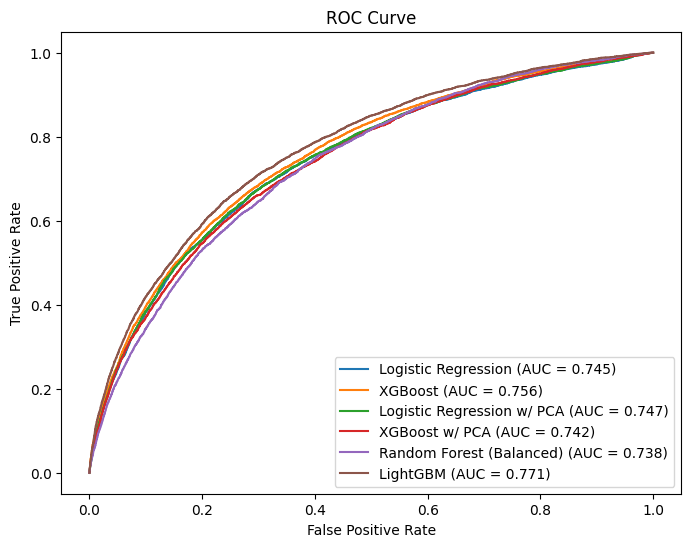

In [11]:
model_file_names = ['logistic_regression_plain','xgboost_plain','logistic_regression_plain_w_pca','xgboost_plain_w_pca', 'random_forest_plain','lightgbm_tuned']
legend_names = ['Logistic Regression', 'XGBoost', 'Logistic Regression w/ PCA', 'XGBoost w/ PCA', 'Random Forest (Balanced)','LightGBM']

sns.reset_orig()

application_test = pd.read_csv('train_val_data/test.csv')
X = application_test.drop(columns=['TARGET'])
y = application_test['TARGET']
data = dict()
for model_file_name in model_file_names:
    with open('models/'+model_file_name+'_models.pickle', 'rb') as handle:
        models = pickle.load(handle)
    data[model_file_name] = predict_proba(X)

plt.figure(figsize=(8, 6))
for idx,model_file_name in enumerate(model_file_names):
    y_pred = data[model_file_name]
    fpr, tpr, _ = roc_curve(y, y_pred)
    plt.plot(fpr, tpr, label=f'{legend_names[idx]} (AUC = {roc_auc_score(y, y_pred):.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()